# Tilted solid-body rotation

If you've already looked at the stream function conservation examples in the [horizontal](./hor_stream) and [vertical](./ver_stream) examples, you may still have the following doubts:

1. What if the flow is not 2D/not aligned with the grid direction?
1. If the velocity components are all scaled by a factor, the streamlines will still be the same.

This notebook is designed to address those doubts. We use a tilted solid body rotation with known orbit frequency for demonstration. As far as the package is concerned, tilted 2D flow is not different from fully 3D flow.

In [22]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
import xarray as xr
from PIL import Image

import seaduck as sd

mpl.rcParams["figure.dpi"] = 300

warnings.filterwarnings("ignore")

## Loading data

First, we prepare the grid of the dataset

In [23]:
M = 100
N = 100

x = np.linspace(-1, 1, N + 1)
y = np.linspace(-1, 1, M + 1)
dy = y[1] - y[0]
xg, yg = np.meshgrid(x, y)

xv = 0.5 * (xg[:, 1:] + xg[:, :-1])
yv = 0.5 * (yg[:, 1:] + yg[:, :-1])
xu = 0.5 * (xg[1:] + xg[:-1])
yu = 0.5 * (yg[1:] + yg[:-1])

xc = 0.5 * (xv[1:] + xv[:-1])
yc = 0.5 * (yv[1:] + yv[:-1])

zp1 = np.linspace(0, -4, M + 1)
z = 0.5 * (zp1[1:] + zp1[:-1])
zl = zp1[:-1]
drf = np.abs(np.diff(zp1))

Calculate the solid-body velocity in the horizontal directions:

In [24]:
def solid_body(x, y):
    omega = 1
    r = np.hypot(x, y)
    speed = np.zeros_like(x)
    speed = omega * r

    u = -y / r * speed
    v = x / r * speed
    return u, v

In [25]:
u, _ = solid_body(xu, yu)
_, v = solid_body(xv, yv)

We define the angle of the tilt of the velocity field:

In [26]:
angle = np.pi / 6
tan = np.tan(angle)

The vertical velocity is proportional to the $v$ velocity by the tangent of the angle we just defined:

In [27]:
vc = 0.5 * (v[1:] + v[:-1])
zygrid = drf[0] / dy
w = tan * vc / zygrid

In [28]:
u = np.tile(u, (len(z), 1, 1))
v = np.tile(v, (len(z), 1, 1))
w = np.tile(w, (len(z), 1, 1))

Now, we can assemble the parts to create the `xarray.Dataset`:

In [29]:
ds = xr.Dataset(
    coords=dict(
        XC=(["Y", "X"], xc),
        YC=(["Y", "X"], yc),
        XG=(["Yp1", "Xp1"], xg),
        YG=(["Yp1", "Xp1"], yg),
        rA=(["Y", "X"], np.ones_like(xc, float)),
        Zp1=(["Zp1"], zp1),
        Zl=(["Zl"], zl),
        Z=(["Z"], z),
        drF=(["Z"], drf),
    ),
    data_vars=dict(
        UVELMASS=(["Z", "Y", "Xp1"], u),
        VVELMASS=(["Z", "Yp1", "X"], v),
        WVELMASS=(["Zl", "Y", "X"], w),
    ),
)
ds

<xarray.Dataset>
Dimensions:   (Z: 100, Y: 100, Xp1: 101, Yp1: 101, X: 100, Zl: 100, Zp1: 101)
Coordinates:
    XC        (Y, X) float64 -0.99 -0.97 -0.95 -0.93 ... 0.93 0.95 0.97 0.99
    YC        (Y, X) float64 -0.99 -0.99 -0.99 -0.99 ... 0.99 0.99 0.99 0.99
    XG        (Yp1, Xp1) float64 -1.0 -0.98 -0.96 -0.94 ... 0.94 0.96 0.98 1.0
    YG        (Yp1, Xp1) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 1.0 1.0 1.0 1.0
    rA        (Y, X) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
  * Zp1       (Zp1) float64 0.0 -0.04 -0.08 -0.12 ... -3.88 -3.92 -3.96 -4.0
  * Zl        (Zl) float64 0.0 -0.04 -0.08 -0.12 ... -3.84 -3.88 -3.92 -3.96
  * Z         (Z) float64 -0.02 -0.06 -0.1 -0.14 ... -3.86 -3.9 -3.94 -3.98
    drF       (Z) float64 0.04 0.04 0.04 0.04 0.04 ... 0.04 0.04 0.04 0.04 0.04
Dimensions without coordinates: Y, Xp1, Yp1, X
Data variables:
    UVELMASS  (Z, Y, Xp1) float64 0.99 0.99 0.99 0.99 ... -0.99 -0.99 -0.99
    VVELMASS  (Z, Yp1, X) float64 -0.99 -0.97 -0.95 -0.93 ... 0.95 0.97 0.99
    WVELMASS  (Zl, Y, X) float64 -0.2858 -0.28 -0.2742 ... 0.2742 0.28 0.2858

## Prepare the test

As always, convert `xarray.Dataset` to `seaduck.OceData`:

In [30]:
tub = sd.OceData(ds)

Now we define the initial position. For reasons that will be clear in a minute, we define the particle on a plane that is parallel to the velocity field.

In [31]:
n = 64
m = 64
edge = 0.3
x = np.linspace(-edge, edge, n)
y = np.linspace(-edge, edge, m)
x, y = np.meshgrid(x, y)

In [32]:
x = x.ravel()
y = y.ravel()

z = -2 + tan * y

A coloring scheme is defined here to help human eyes to identify the patterns. We also define a function here that allows us to look at the particles along the $x$, $y$, and $z$ axes.

In [33]:
file_path = pooch.retrieve(
    url="https://github.com/MaceKuailv/seaduck/blob/main/docs/logo.png?raw=true",
    known_hash="bed53271c0356006eb02751040b7a10536b853872de1c728106ee56227b7c0f8",
)
image = Image.open(file_path)
rgb = np.asarray(image)

bins = 1024 // n
particle_color = rgb[::-bins, ::bins].reshape(len(x), 3) / 255


def plot_particle3d(pt, c=particle_color, s=8):
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 3, 1)
    ax1.scatter(pt.lat, pt.dep, c=c, s=s)
    ax1.set_ylabel("z")
    ax1.set_xlabel("y")
    ax1.set_title("Y-Z plane")

    ax2 = plt.subplot(1, 3, 2)
    ax2.scatter(pt.lon, pt.dep, c=c, s=s)
    ax2.set_ylabel("z")
    ax2.set_xlabel("x")
    ax2.set_title("X-Z plane")

    ax3 = plt.subplot(1, 3, 3)
    ax3.scatter(pt.lon, pt.lat, c=c, s=s)
    ax3.set_ylabel("y")
    ax3.set_xlabel("x")
    ax3.set_title("X-Y plane")

    return fig

## Run the test

Let's take a look at the initial condition:

In [34]:
pt = sd.Particle(x=x, y=y, z=z, t=np.zeros_like(x), data=tub, transport=True)

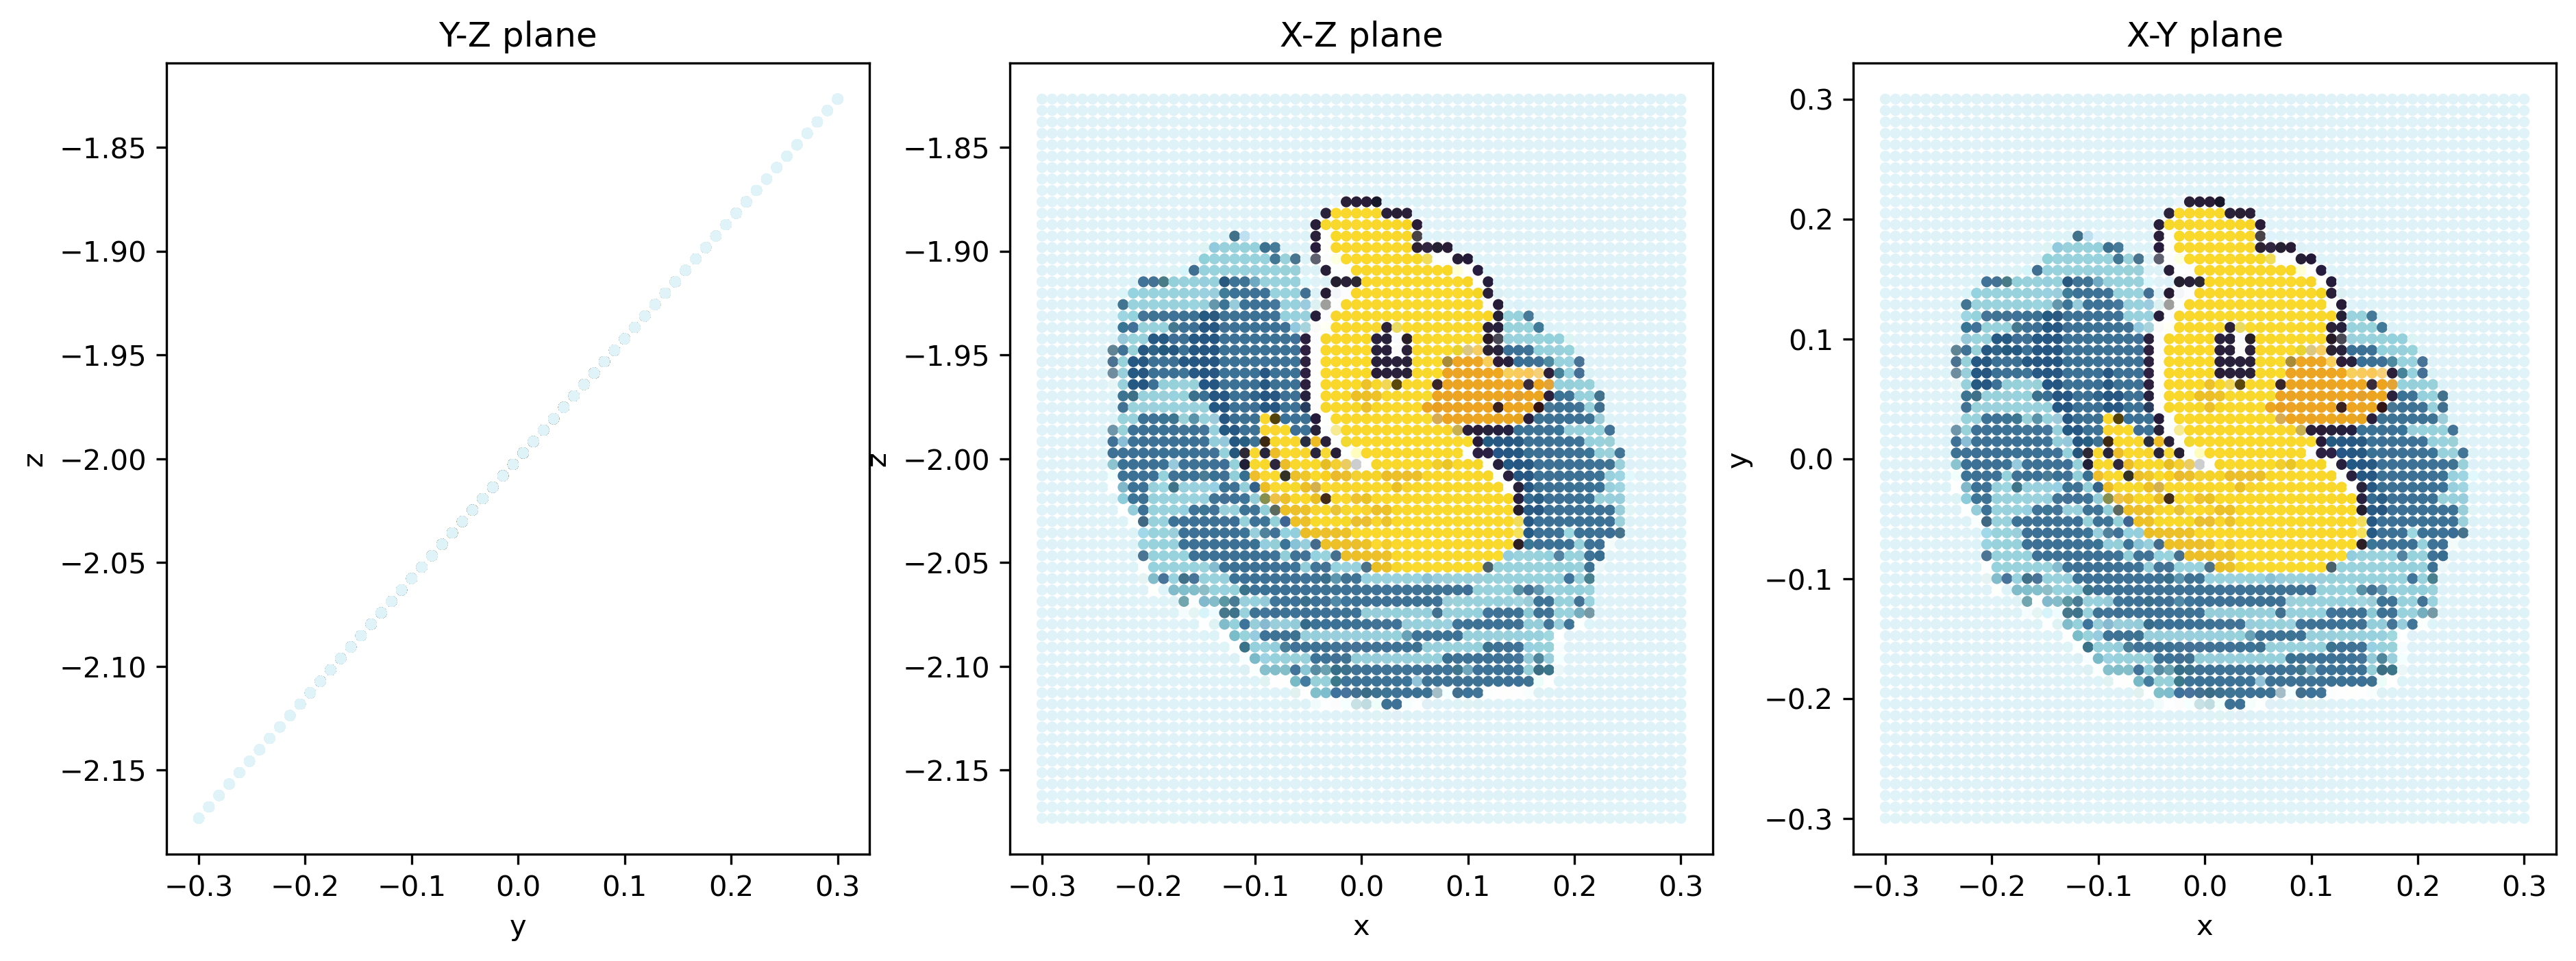

In [35]:
plot_particle3d(pt)
plt.show()

Note that on the $y$-$z$ plane, the particles are aligned on a single straight line.

Now see what happens when we try to run the particles to turn them exactly 180 $^{\circ}$.

In [36]:
pt.to_next_stop(np.pi * 2)

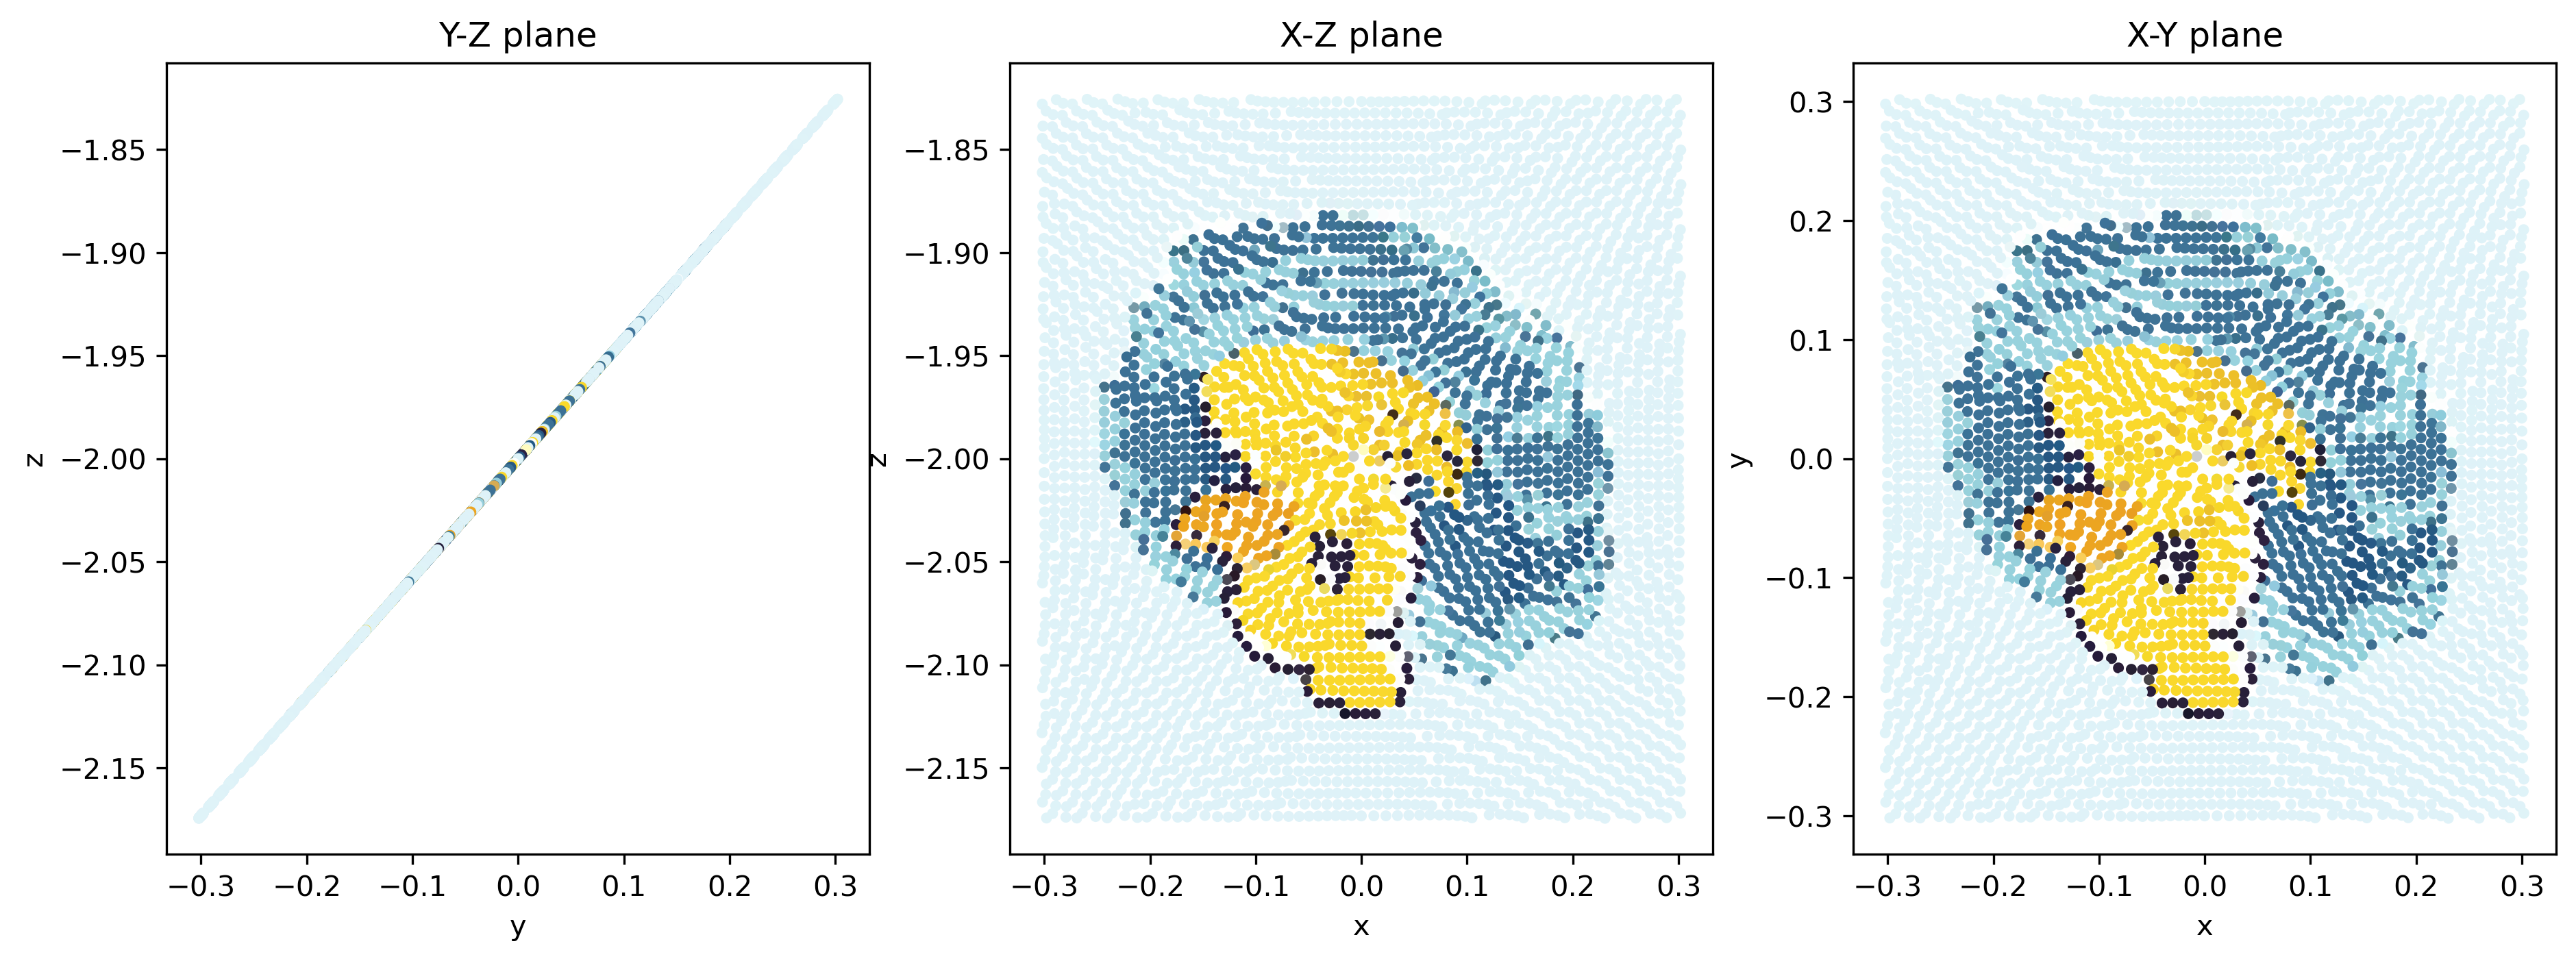

In [37]:
plot_particle3d(pt)
plt.show()

It turns exactly 180 $^{\circ}$! And from the $y$-$z$ plane, it stays a straight line!

You may noticed that the relative position of particles has changed a little. This is because the motion defined by the finite resolution gridded dataset is not a perfect solid-body rotation. However, it is pretty close!

Can you turn it backward a little to get a golden ratio?

In [38]:
pt.to_next_stop(np.pi * 1.618)

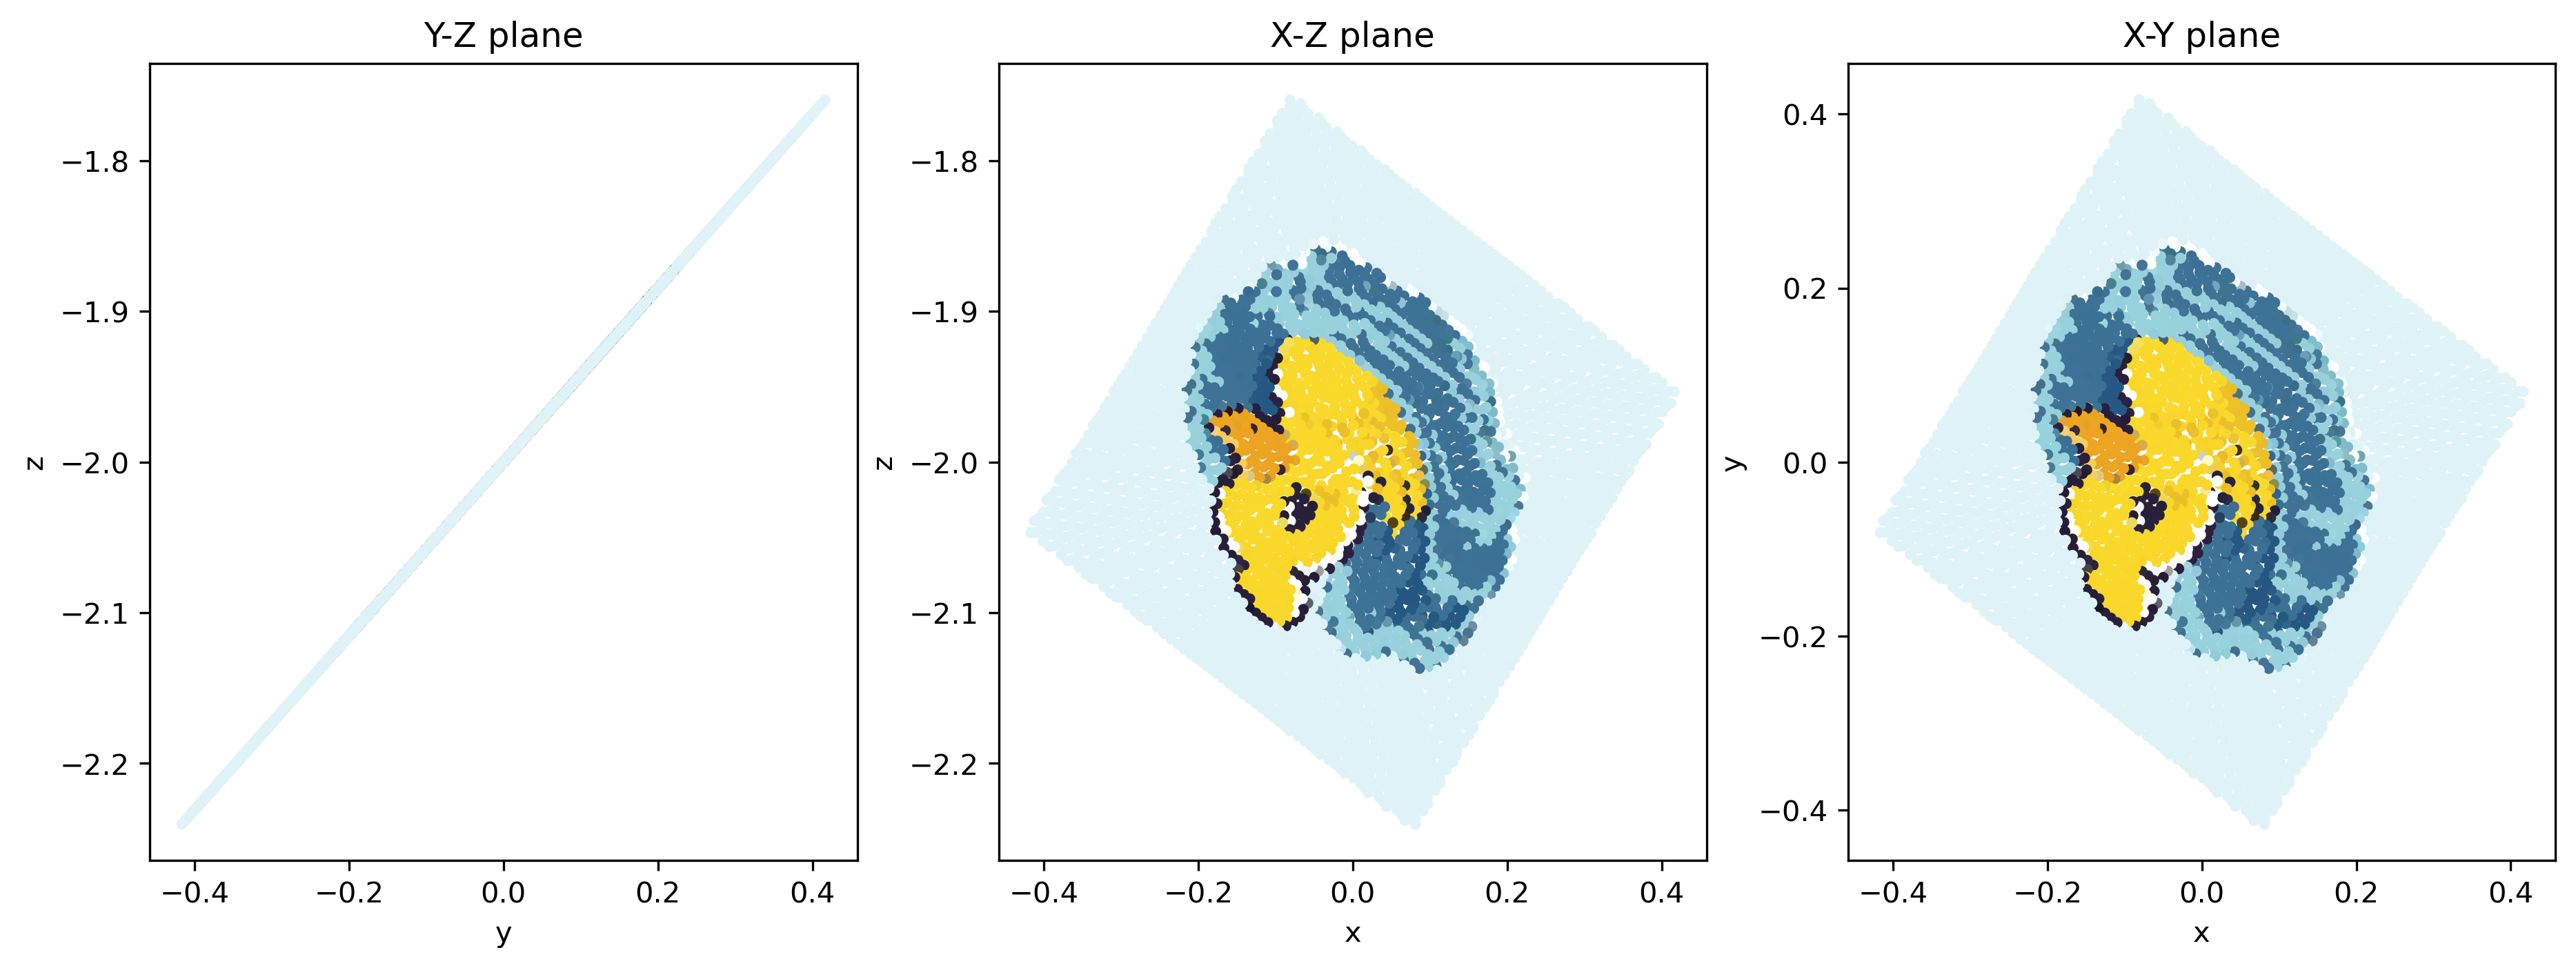

In [39]:
plot_particle3d(pt)
plt.show()

Yes!

What is more impressive is that we can run it back to the initial time. Look what happens:

In [40]:
pt.to_next_stop(0.0)

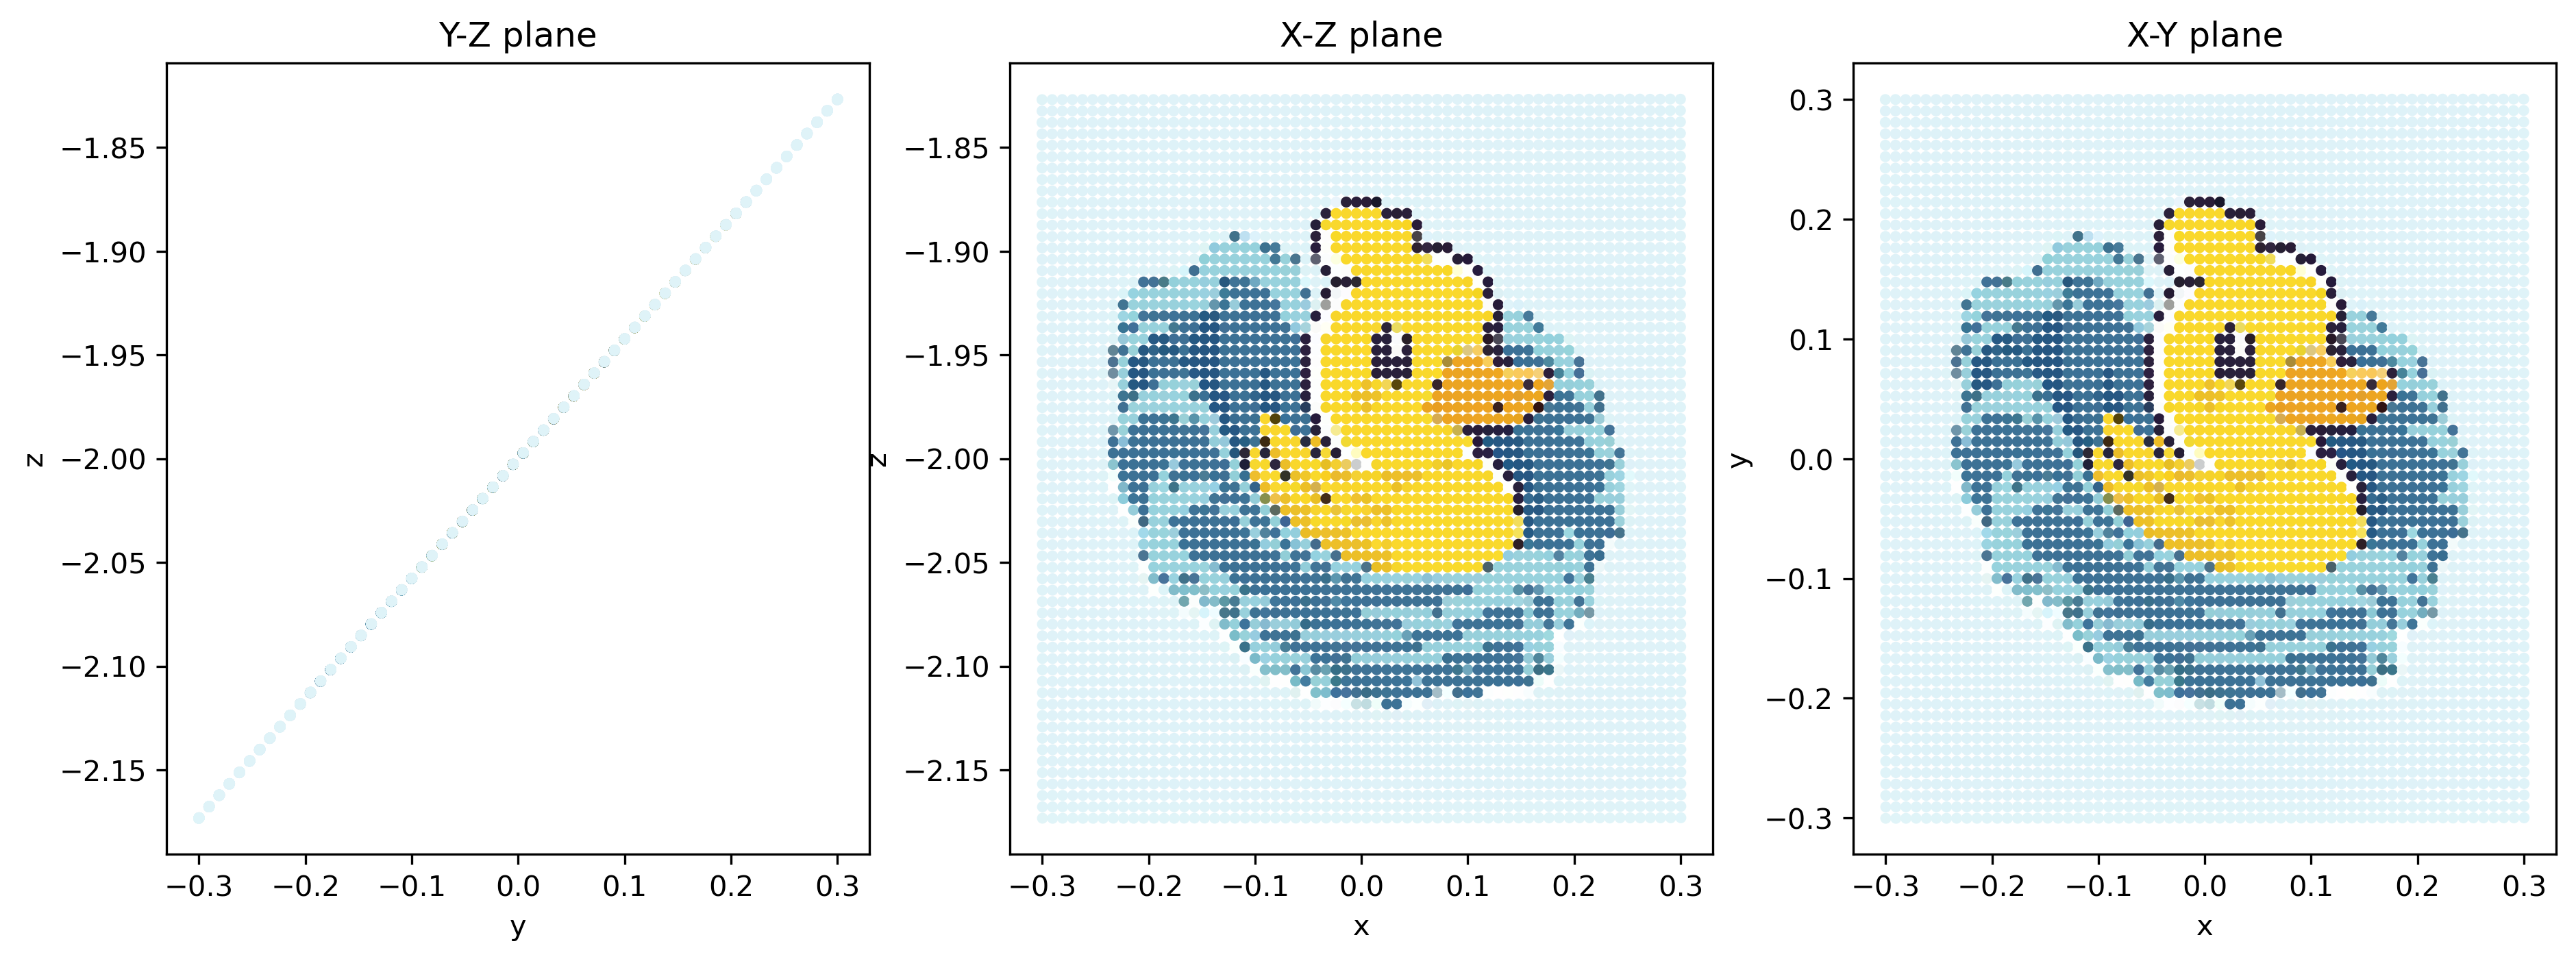

In [41]:
plot_particle3d(pt)
plt.show()

It looks identical to the initial condition!

You have to take my words for it: we **did not** cache the positions (no cheating!).

Some small (roundoff) errors are introduced during our handling of the particles, so it's not completely reversible. Let's check:

In [43]:
np.std(pt.lon - x), np.std(pt.lat - y), np.std(pt.dep - z)

(9.698668626724355e-05, 9.58504213719265e-05, 6.141648223854299e-05)

Bu these are pretty small errors!